In [33]:
import numpy as np
from numpy import cos , sin , tan , sqrt
import time
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as mplt
import cartopy.crs as ccrs
from cartopy import config
import cartopy.feature
from IPython.display import display, Math
import unicodedata
from sympy import Matrix

In [39]:
def f(n):
    if n == 0:
        return 0.
    elif n == 1:
        return sqrt( (2.*n+1.)/n )
    else:
        return sqrt( (2.*n+1.)/(2.*n) )
    
def g(n , m):
    if n == m:
        return 0.
    else:
        return sqrt( (4.*n**2 - 1.)/(n**2 - m**2) )
    
def h(n , m):
    if n == m:
        return 0.
    else:
        return sqrt( ( (2.*n + 1.)*( (n - 1.)**2 - m**2) )/( (2.*n - 3.)*(n**2 - m**2) ) )
    
def k(n , m):
    if m == 0:
        return sqrt( (n - m)*(n + m + 1.)/2. )
    else:
        return sqrt( (n - m)*(n + m + 1.) )
    
print( 'Coefficients Functions, OK!' )

def cos_and_sin(  lam , n_max ):

    g = len(lam)
    CS = np.zeros( ( n_max , g , 2 ) )
    LAM = np.deg2rad(lam)

    for i in range( g ):
        l = LAM[i]
        for m in range( n_max ):
            p = m*l
            CS[m,i,0] = cos(p)
            CS[m,i,1] = sin(p)
            
    return CS

print('COSSIN ok!')

def ALF( n_max , phi , F , G , H , K ):
    
    gp = len(phi)
    P = np.zeros( ( n_max , n_max , len(phi) , 3 ) )

    Phi = np.deg2rad(phi)
    
    P[0,0,:,0] = 1.

    for i in range( gp ):

        c = cos(Phi[i])
        s = sin(Phi[i])
        t = tan(Phi[i])

        P[1,0,i,0] = sqrt(3.)*s
        P[1,1,i,0] = sqrt(3.)*c

        m = 0
        n = 2

        while n < n_max:  

            P[n,m,i,0] = G[n,m]*P[n-1,m,i,0]*s - H[n,m]*P[n-2,m,i,0]
            P[n,m+1,i,0] = G[n,m]*P[n-1,m+1,i,0]*s - H[n,m]*P[n-2,m+1,i,0]
            P[n,m,i,1] = K[n,m]*P[n,m+1,i,0] - m*t*P[n,m,i,0]
            P[n,m,i,2] = P[n,m,i,0]*( ( m/(c*c) )*( m - (s*s) ) - n*(n+1) ) + t*K[n,m]*P[n,m+1,i,0]
                                       
            m = m + 1

            if m == n:

                P[n,n,i,0] = F[n]*c*P[n-1,n-1,i,0]
                P[n,n,i,1] = -n*t*P[n,n,i,0]
                P[n,n,i,2] = n*P[n,n,i,0]*( ( n - s**2 )/( c**2 ) - n - 1 )

                n = n + 1
                m = 0

    return P

print('Legendre done!')

#################################################################################################################################
######################################## LUMPED COEFFICIENTS FUNCTIONS ##########################################################
#################################################################################################################################

def Lumped_py( r , phi , n_max , gnm , hnm , P , dP , ddP , a , g1 ):
    
    ini = 0
    
    if g1 == 0:
        ini = 2
    
    g = len(phi)
    rr = 1/r
    Y = a*rr

    Lump = np.zeros( ( 6 , g , n_max ) )

    for i in range( g ):
        for m in range( n_max ):

            A , B , Ar , Br , Ap , Bp = 0 , 0 , 0 , 0 , 0 , 0 

            for n in range( ini ):

                A += P[ n , m , i ]*gnm[ n , m ]*(Y**n)
                B += P[ n , m , i ]*hnm[ n , m ]*(Y**n)

                Ar += P[ n , m , i ]*gnm[ n , m ]*(Y**n)*n
                Br += P[ n , m , i ]*hnm[ n , m ]*(Y**n)*n
                Ap += dP[ n , m , i ]*gnm[ n , m ]*(Y**n)
                Bp += dP[ n , m , i ]*hnm[ n , m ]*(Y**n)


            Lump[ 0 , i , m  ] = A # Am
            Lump[ 1 , i , m  ] = B # Bm

            Lump[ 2 , i , m ] = (-rr)*Ar # dAm/dr
            Lump[ 3 , i , m ] = (-rr)*Br # dBm/dr
            Lump[ 4 , i , m ] = Ap # dAm/dp
            Lump[ 5 , i , m ] = Bp # dBm/dp


    return Lump

print( 'Lumped Coefficients, done!' )

#################################################################################################################################
######################################## POTENTIAL FUNCTION #####################################################################
#################################################################################################################################

def Potential( r , lam , phi , n_max , COS , SIN , A , B , a ): # Lumped coefficients

    g1 = len(phi)
    g2 = len(lam)
    
    Pot = np.zeros( ( g1 , g2 ) )

    J = a*a/r 
    
    for i in range( g1 ):
        for j in range( g2 ):
            Cor = 0.          
            for m in range( n_max ):
                Cor = Cor + A[ i , m ]*COS[ m , j ] + B[ i , m ]*SIN[ m , j ]
            Pot[ i , j ] = J*Cor
    return Pot

print( 'Function OK!' )

#################################################################################################################################
######################################## NABLA POTENTIAL FUNCTION #####################################################################
#################################################################################################################################

def Nabla_Potential( r , lam , phi , n_max , COS , SIN , A , B , Ar , Br , Ap , Bp , a ):

    g1 = len(phi)
    g2 = len(lam)
    
    dPot = np.zeros( ( g1 , g2 , 3 ) )

    J = a*a/r
    
    for i in range( g1 ):
        for j in range( g2 ):
            Cor_r = 0.   
            Cor_p = 0.
            Cor_l = 0.       
            for m in range( n_max ):
                alpha = COS[ m , j ]
                beta = SIN[ m , j ]
                Cor_r = Cor_r + alpha*( Ar[ i , m ] - ( A[ i , m ]/r ) ) + beta*( Br[ i , m ] - ( B[ i , m ]/r ) )
                Cor_p = Cor_p + alpha*Ap[ i , m ] + beta*Bp[ i , m ]
                Cor_l = Cor_l + m*( -A[ i , m ]*beta + B[ i , m ]*alpha )
            dPot[ i , j , 0 ] = J*Cor_r
            dPot[ i , j , 1 ] = J*Cor_p
            dPot[ i , j , 2 ] = J*Cor_l
    return dPot

print( 'Potential gradient function, OK!' )

#################################################################################################################################
######################################## B components FUNCTION #####################################################################
#################################################################################################################################

def BMODULE(r , phi , lam , nablaVr , nablaVp , nablaVl):
    
    Bmodule = np.zeros( (len(phi) , len(lam)) )
    
    Phi = np.deg2rad(phi)
    
    for i in range(len(phi)):
        s = sin(Phi[i])
        for j in range(len(lam)):
            b1 = -nablaVr[i,j]
            b2 = -nablaVp[i,j]/r
            b3 = -nablaVl[i,j]/(r*s)
            Bmodule[i,j] = sqrt(b1*b1 + b2*b2 + b3*b3)
            
    return Bmodule

print('magnetic yzi')

def GAUSS( Name , N , M , IGRF , n_max):
    
    cont = int(max(N))+1
            
    gnm = np.zeros( (cont , cont) ) 
    hnm = np.zeros( (cont , cont) ) 

    for j in range( len(Name) ):
        
        l = int(N[j])
        k = int(M[j])
        
        if Name[j] == str('g'):
            gnm[l,k] = IGRF[j]
        else:
            hnm[l,k] = IGRF[j]
    
    return gnm , hnm

Coefficients Functions, OK!
COSSIN ok!
Legendre done!
Lumped Coefficients, done!
Function OK!
Potential gradient function, OK!
magnetic yzi


In [40]:
t_in = time.perf_counter()

# Earth : 
GM , a , n_max , Earth , A = 3.986004415e14 , 6.378137e6 , 13 , True , np.genfromtxt( 'Gauss_coeffs.txt' , comments = '#' )

r = a
res = 1

Name = ['g' , 'g' , 'h' , 'g' , 'g' , 'h' , 'g' , 'h' , 'g' , 'g' , 'h' , 'g' , 'h' , 'g' , 'h' , 'g' , 'g' , 'h' , 'g' , 'h' , 'g' , 'h' , 'g' , 'h' , 'g' , 'g' , 'h' , 'g' , 'h' , 'g' , 'h' , 'g' , 'h' , 'g' , 'h', 'g' , 'g' , 'h' , 'g' , 'h' , 'g' , 'h' , 'g' , 'h' , 'g' , 'h' , 'g' , 'h' , 'g' , 'g' , 'h' , 'g' , 'h' , 'g' , 'h' , 'g' , 'h' , 'g' , 'h' , 'g' , 'h' , 'g' , 'h' , 'g' , 'g' , 'h' , 'g' , 'h' , 'g' , 'h' , 'g' , 'h' , 'g' , 'h' , 'g' , 'h' , 'g' , 'h' , 'g' , 'h' , 'g' , 'g' , 'h' , 'g' , 'h' , 'g' , 'h' , 'g' , 'h' , 'g' , 'h' , 'g' , 'h' , 'g' , 'h' , 'g' , 'h' , 'g' , 'h' , 'g' , 'g' , 'h' , 'g' , 'h' , 'g' , 'h' , 'g' , 'h' , 'g' , 'h' , 'g' , 'h' , 'g' , 'h' , 'g' , 'h' , 'g' , 'h' , 'g' , 'h' , 'g' , 'g' , 'h' , 'g' , 'h' , 'g' , 'h' , 'g' , 'h' , 'g' , 'h' , 'g' , 'h' , 'g' , 'h' , 'g' , 'h' , 'g' , 'h' , 'g' , 'h' , 'g' , 'h' , 'g' , 'g' , 'h' , 'g' , 'h' , 'g' , 'h' , 'g' , 'h' , 'g' , 'h' , 'g' , 'h' , 'g' , 'h' , 'g' , 'h' , 'g' , 'h' , 'g' , 'h' , 'g' , 'h' , 'g' , 'h' , 'g' ,'g' , 'h' , 'g' , 'h' , 'g' , 'h' , 'g' , 'h' , 'g' , 'h' , 'g' , 'h' , 'g' , 'h' , 'g' , 'h' , 'g' , 'h' , 'g' , 'h' , 'g' , 'h' , 'g' , 'h' , 'g' , 'h']
N = A[:,1] 
M = A[:,2] 
IGRF = A[:,3] 

gnm , hnm = GAUSS(Name , N , M , IGRF , n_max)

print( "Number of coefficients: " , n_max )

phi = np.linspace( 90. , -90. , 180*res )
lam = np.linspace( -180. , 180. , 360*res )

F = np.zeros( n_max )
G = np.zeros( ( n_max , n_max ) )
H = np.zeros( ( n_max , n_max ) )
K = np.zeros( ( n_max , n_max ) )

# f , g , h , k coefficients
for n in range(n_max):
    F[n] = f(n)
    for m in range(n+1):
        G[n , m] = g(n , m)
        H[n , m] = h(n , m)
        K[n , m] = k(n , m)

save = False

t_fin = time.perf_counter()

print( "Time for computation = " , " {:10.4f}".format( t_fin - t_in ) , ' s' )

print('everything done!')
print()
print('gnm =')
display(Matrix(gnm))
print()
print('hnm = ')
display(Matrix(hnm))

Number of coefficients:  13
Time for computation =       0.0056  s
everything done!

gnm =


Matrix([
[     0.0,     0.0,    0.0,    0.0,   0.0,   0.0,   0.0, 0.0,  0.0,  0.0, 0.0, 0.0, 0.0, 0.0],
[-31543.0, -2298.0,    0.0,    0.0,   0.0,   0.0,   0.0, 0.0,  0.0,  0.0, 0.0, 0.0, 0.0, 0.0],
[  -677.0,  2905.0,  924.0,    0.0,   0.0,   0.0,   0.0, 0.0,  0.0,  0.0, 0.0, 0.0, 0.0, 0.0],
[  1022.0, -1469.0, 1256.0,  572.0,   0.0,   0.0,   0.0, 0.0,  0.0,  0.0, 0.0, 0.0, 0.0, 0.0],
[   876.0,   628.0,  660.0, -361.0, 134.0,   0.0,   0.0, 0.0,  0.0,  0.0, 0.0, 0.0, 0.0, 0.0],
[  -184.0,   328.0,  264.0,    5.0, -86.0, -16.0,   0.0, 0.0,  0.0,  0.0, 0.0, 0.0, 0.0, 0.0],
[    63.0,    61.0,  -11.0, -217.0, -58.0,  59.0, -90.0, 0.0,  0.0,  0.0, 0.0, 0.0, 0.0, 0.0],
[    70.0,   -55.0,    0.0,   34.0, -41.0, -21.0,  18.0, 6.0,  0.0,  0.0, 0.0, 0.0, 0.0, 0.0],
[    11.0,     8.0,   -4.0,   -9.0,   1.0,   2.0,  -9.0, 5.0,  8.0,  0.0, 0.0, 0.0, 0.0, 0.0],
[     8.0,    10.0,    1.0,  -11.0,  12.0,   1.0,  -2.0, 2.0, -1.0, -1.0, 0.0, 0.0, 0.0, 0.0],
[    -3.0,    -4.0,    2.0,   -5.0,  -2.0


hnm = 


Matrix([
[0.0,     0.0,    0.0,    0.0,    0.0,  0.0,   0.0,   0.0,   0.0, 0.0,  0.0, 0.0, 0.0, 0.0],
[0.0,  5922.0,    0.0,    0.0,    0.0,  0.0,   0.0,   0.0,   0.0, 0.0,  0.0, 0.0, 0.0, 0.0],
[0.0, -1061.0, 1121.0,    0.0,    0.0,  0.0,   0.0,   0.0,   0.0, 0.0,  0.0, 0.0, 0.0, 0.0],
[0.0,  -330.0,    3.0,  523.0,    0.0,  0.0,   0.0,   0.0,   0.0, 0.0,  0.0, 0.0, 0.0, 0.0],
[0.0,   195.0,  -69.0, -210.0,  -75.0,  0.0,   0.0,   0.0,   0.0, 0.0,  0.0, 0.0, 0.0, 0.0],
[0.0,  -210.0,   53.0,  -33.0, -124.0,  3.0,   0.0,   0.0,   0.0, 0.0,  0.0, 0.0, 0.0, 0.0],
[0.0,    -9.0,   83.0,    2.0,  -35.0, 36.0, -69.0,   0.0,   0.0, 0.0,  0.0, 0.0, 0.0, 0.0],
[0.0,   -45.0,  -13.0,  -10.0,   -1.0, 28.0, -12.0, -22.0,   0.0, 0.0,  0.0, 0.0, 0.0, 0.0],
[0.0,     8.0,  -14.0,    7.0,  -13.0,  5.0,  16.0,  -5.0, -18.0, 0.0,  0.0, 0.0, 0.0, 0.0],
[0.0,   -20.0,   14.0,    5.0,   -3.0, -2.0,   8.0,  10.0,  -2.0, 2.0,  0.0, 0.0, 0.0, 0.0],
[0.0,     2.0,    1.0,    2.0,    6.0, -4.0,   0.0,  -2.0,   

In [45]:
t_in = time.perf_counter()
cands = cos_and_sin( lam , n_max )
t_fin = time.perf_counter()

COS = cands[:,:,0]
SIN = cands[:,:,1]

print( "Time for computation COSSIN = " , " {:10.4f}".format( t_fin - t_in ) , ' s' )

t_in = time.perf_counter()
Legendre_func = ALF( n_max , phi , F , G , H , K )
t_fin = time.perf_counter()

P = Legendre_func[:,:,:,0]
dP = Legendre_func[:,:,:,1]
ddP = Legendre_func[:,:,:,2]

print( "Time for computation nALF = " , " {:10.4f}".format( t_fin - t_in ) , ' s' )

t_in = time.perf_counter()

L_Coeffs = Lumped_py( r , phi , n_max , gnm , hnm , P , dP , ddP , a , 1 )

A , B = L_Coeffs[0,:,:] , L_Coeffs[1,:,:]

Ar , Br = L_Coeffs[2,:,:] , L_Coeffs[3,:,:]
Ap , Bp = L_Coeffs[4,:,:] , L_Coeffs[5,:,:]

t_fin = time.perf_counter()

print( "Time for computation LUMPCOEFFS = " , " {:10.4f}".format( t_fin - t_in ) , ' s' )

t_in = time.perf_counter()
Pot = Potential( r , lam , phi , n_max , COS , SIN , A , B , a )
t_fin = time.perf_counter()


print( "Time for computation  V = " , " {:10.4f}".format( t_fin - t_in ) , ' s' )

t_in = time.perf_counter()
nabla_Pot  = Nabla_Potential( r , lam , phi , n_max , COS , SIN , A , B , Ar , Br , Ap , Bp , a )
t_fin = time.perf_counter()

print( "Time for computation nablaV = " , " {:10.4f}".format( t_fin - t_in ) , ' s' )

t_in = time.perf_counter()
B = BMODULE( r , phi , lam , nabla_Pot[:,:,0] , nabla_Pot[:,:,1] , nabla_Pot[:,:,2] )
t_fin = time.perf_counter()

print( "Time for computation magnetic field = " , " {:10.4f}".format( t_fin - t_in ) , ' s' )

display(Matrix(Pot))

Time for computation COSSIN =       0.0118  s
Time for computation nALF =       0.0838  s
Time for computation LUMPCOEFFS =       0.0024  s
Time for computation  V =       0.7401  s
Time for computation nablaV =       2.6626  s
Time for computation magnetic field =       0.1652  s


Matrix([
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

**-------------------------------------------------------------------------------------------------------------------------------------------------------------------**

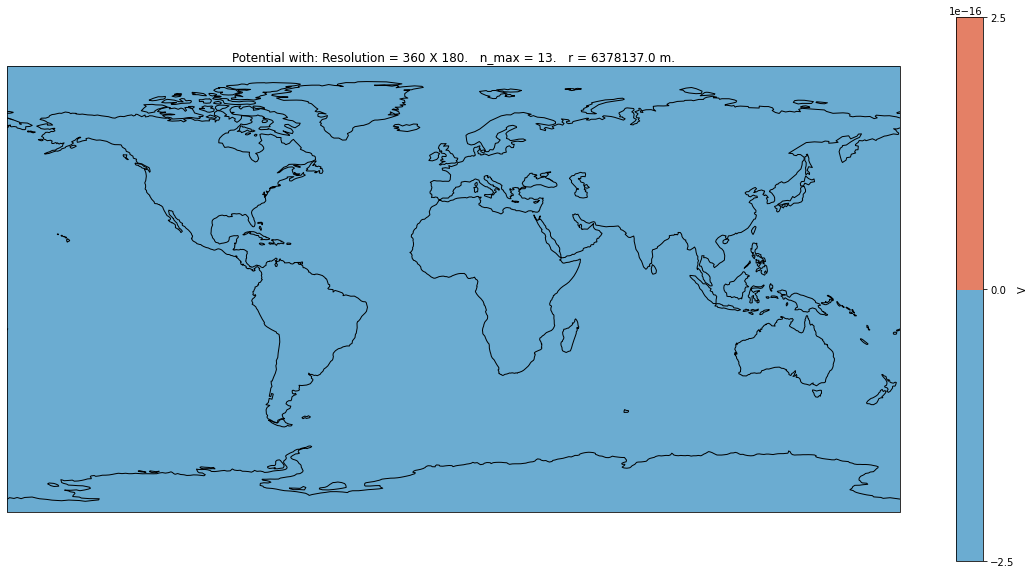

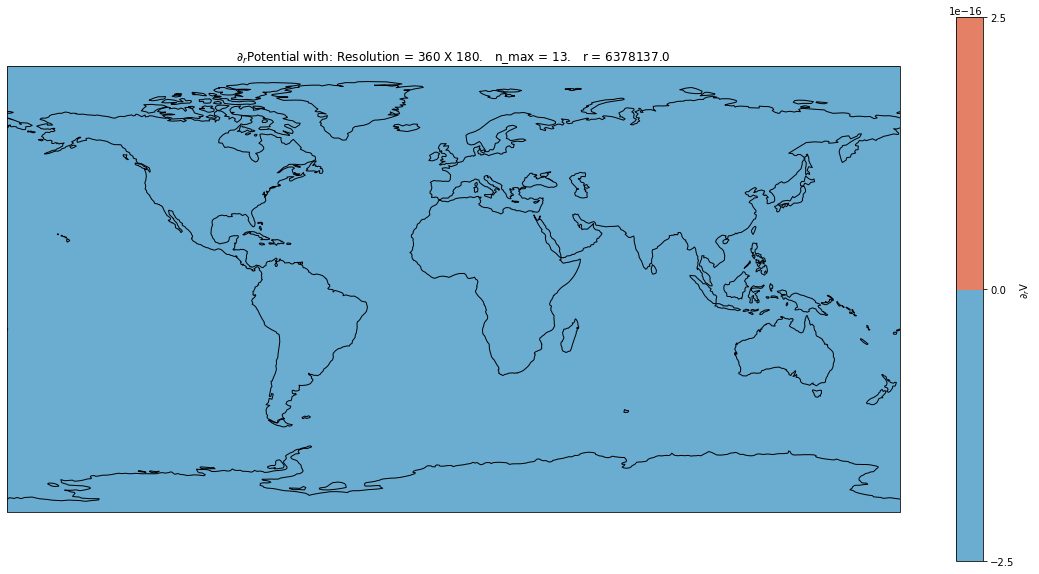

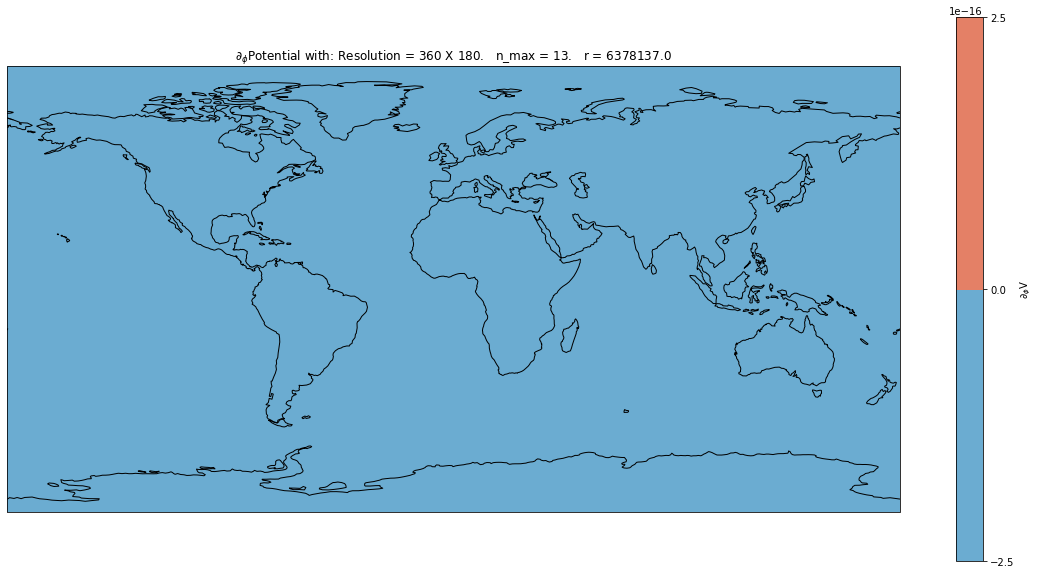

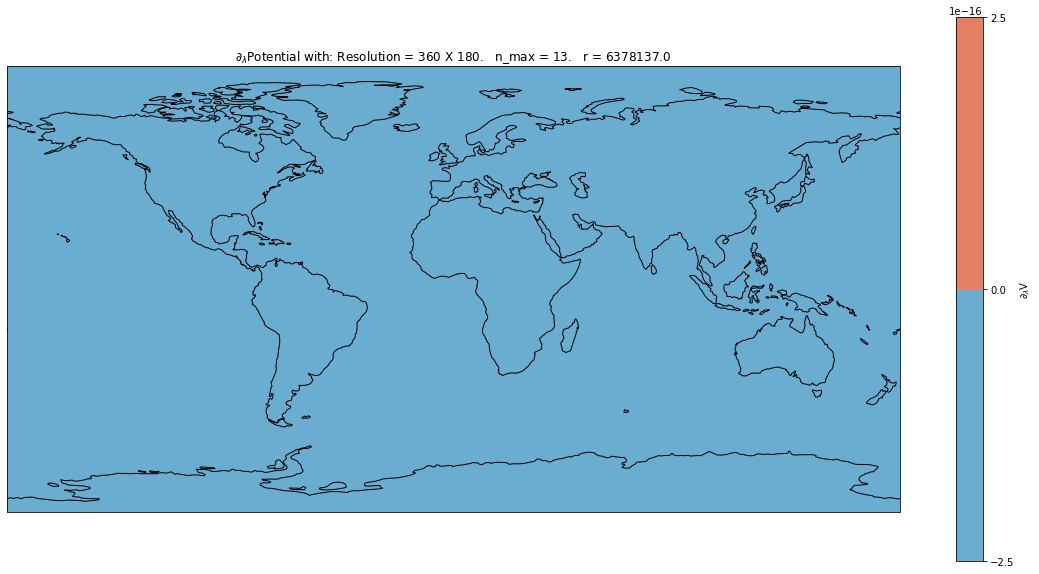

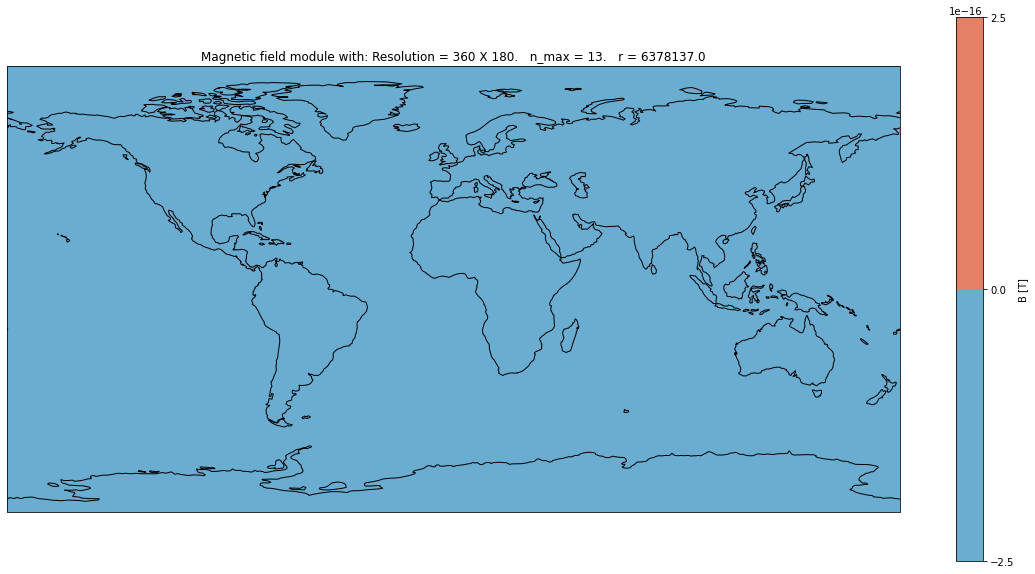

In [42]:
plt.figure( figsize = [ 20 , 10 ] )

ax = plt.axes( projection=ccrs.PlateCarree() )

cs = plt.contourf( lam , phi , Pot , 900  , transform=ccrs.PlateCarree() , cmap = cm.RdBu_r )

if Earth == True:
    ax.coastlines()
    
cbar = plt.colorbar( cs , orientation='vertical' )#, format=mplt.FuncFormatter(fmt) )
cbar.set_label( 'V' , rotation=90 )
cbar.solids.set_edgecolor( "face" )

plt.xlabel( '$\lambda$ [deg]' )
plt.ylabel( '$\phi$ [deg]' )

plt.title( 'Potential with: Resolution = ' + str(len(lam)) + ' X ' + str(len(phi)) + '.   n_max = ' + str(n_max) + '.   r = ' + str(r) + ' m.')

if save == True:

    plt.savefig( 'V_' + str(len(lam)) + ' X ' + str(len(phi)) + ' n_max' + str(n_max) + '.png' ) 
    
plt.show()

###########################################################################################################

plt.figure( figsize = [ 20 , 10 ] )

ax = plt.axes( projection=ccrs.PlateCarree() )

cs = plt.contourf( lam , phi , nabla_Pot[:,:,0] , 900  , transform=ccrs.PlateCarree() , cmap = cm.RdBu_r )

if Earth == True:
    ax.coastlines()
    
cbar = plt.colorbar( cs , orientation='vertical' )#, format=mplt.FuncFormatter(fmt) )
cbar.set_label( '$\partial_{r}$V' , rotation=90 )
cbar.solids.set_edgecolor( "face" )

plt.xlabel( '$\lambda$ [deg]' )
plt.ylabel( '$\phi$ [deg]' )

plt.title( '$\partial_{r}$Potential with: Resolution = ' + str(len(lam)) + ' X ' + str(len(phi)) + '.   n_max = ' + str(n_max) + '.   r = ' + str(r) )

if save == True:

    plt.savefig( 'drV_' + str(len(lam)) + ' X ' + str(len(phi)) + ' n_max' + str(n_max) + '.png' ) 

plt.show()

###########################################################################################################

plt.figure( figsize = [ 20 , 10 ] )

ax = plt.axes( projection=ccrs.PlateCarree() )

cs = plt.contourf( lam , phi , nabla_Pot[:,:,1] , 900  , transform=ccrs.PlateCarree() , cmap = cm.RdBu_r )

if Earth == True:
    ax.coastlines()
    
cbar = plt.colorbar( cs , orientation='vertical' )#, format=mplt.FuncFormatter(fmt) )
cbar.set_label( '$\partial_{\phi}$V' , rotation=90 )
cbar.solids.set_edgecolor( "face" )

plt.xlabel( '$\lambda$ [deg]' )
plt.ylabel( '$\phi$ [deg]' )

plt.title( '$\partial_{\phi}$Potential with: Resolution = ' + str(len(lam)) + ' X ' + str(len(phi)) + '.   n_max = ' + str(n_max) + '.   r = ' + str(r) )

if save == True:
 
    plt.savefig( 'dpV_' + str(len(lam)) + ' X ' + str(len(phi)) + ' n_max' + str(n_max) + '.png' ) 

plt.show()

###########################################################################################################

plt.figure( figsize = [ 20 , 10 ] )

ax = plt.axes( projection=ccrs.PlateCarree() )

cs = plt.contourf( lam , phi , nabla_Pot[:,:,2] , 900  , transform=ccrs.PlateCarree() , cmap = cm.RdBu_r )

if Earth == True:
    ax.coastlines()
    
cbar = plt.colorbar( cs , orientation='vertical' )#, format=mplt.FuncFormatter(fmt) )
cbar.set_label( '$\partial_{\lambda}$V' , rotation=90 )
cbar.solids.set_edgecolor( "face" )

plt.xlabel( '$\lambda$ [deg]' )
plt.ylabel( '$\phi$ [deg]' )

plt.title( '$\partial_{\lambda}$Potential with: Resolution = ' + str(len(lam)) + ' X ' + str(len(phi)) + '.   n_max = ' + str(n_max) + '.   r = ' + str(r) )

if save == True:

    plt.savefig( 'dlV_' + str(len(lam)) + ' X ' + str(len(phi)) + ' n_max' + str(n_max) + '.png' ) 

plt.show()

###########################################################################################################

plt.figure( figsize = [ 20 , 10 ] )

ax = plt.axes( projection=ccrs.PlateCarree() )

cs = plt.contourf( lam , phi , B , 900  , transform=ccrs.PlateCarree() , cmap = cm.RdBu_r )

if Earth == True:
    ax.coastlines()
    
cbar = plt.colorbar( cs , orientation='vertical' )#, format=mplt.FuncFormatter(fmt) )
cbar.set_label( 'B [T]' , rotation=90 )
cbar.solids.set_edgecolor( "face" )

plt.xlabel( '$\lambda$ [deg]' )
plt.ylabel( '$\phi$ [deg]' )

plt.title( 'Magnetic field module with: Resolution = ' + str(len(lam)) + ' X ' + str(len(phi)) + '.   n_max = ' + str(n_max) + '.   r = ' + str(r) )

if save == True:

    plt.savefig( 'dlV_' + str(len(lam)) + ' X ' + str(len(phi)) + ' n_max' + str(n_max) + '.png' ) 

plt.show()